In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import wordnet
import nltk
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,KFold
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay

In [2]:
from google.colab import files
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
uploaded = files.upload()
import io
text_message = pd.read_csv('spam_text_message.csv')
target=text_message.pop('Category')

mapping={'ham':0,'spam':1}
target=target.map(lambda x: mapping.get(x,x))

X_train,X_test,y_train,y_test=train_test_split(text_message,target,test_size=0.25,random_state=42)
ros = RandomOverSampler(random_state=42,sampling_strategy=1)
#X_res, y_res = ros.fit_resample(text_message, target)

text_train=[]
for x in X_train['Message']:
    text_train.append(x)

text_test=[]
for x in X_test['Message']:
    text_test.append(x)


def pos_tag(x):
    if x.startswith('J'):
        return wordnet.ADJ
    elif x.startswith('V'):
        return wordnet.VERB
    elif x.startswith('N'):
        return wordnet.NOUN
    elif x.startswith('R'):
        return wordnet.ADV
    else:
        return None


def clean_body(input):
    lemmatizer=WordNetLemmatizer()
    tagger=PerceptronTagger()
    docs=[]


    for idx in tqdm(range(len(input))):
        review=re.sub(r'\W',' ',str(input[idx]))
        review=re.sub(r'\s+[a-zA-Z]\s+',' ',review)
        review=re.sub(r'\s+',' ',review,flags=re.I)
        review=re.sub(r'\d',' ',review)
        review=re.sub(r'\b\d+\d',' ',review)
        review=review.lower()
        review=review.split()

        pos=[x[1] for x in tagger.tag(review)]

        review=\
        [lemmatizer.lemmatize(token,pos=pos_tag(tag))\
        if pos_tag(tag)!=None else lemmatizer.lemmatize(token)\
        for token,tag in zip(review,pos)]
        review=' '.join(review)
        docs.append(review)

    return docs

docs_train=clean_body(text_train)
docs_test=clean_body(text_test)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving spam_text_message.csv to spam_text_message.csv


100%|██████████| 1393/1393 [00:01<00:00, 1159.64it/s]


In [3]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words = stopwords.words('english'))


# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(docs_train)
vectorizer.get_feature_names_out()[-100:]

array(['word morning', 'word ok', 'word start', 'work', 'work even',
       'work get', 'work place', 'work please', 'workin', 'working',
       'world', 'world god', 'world th', 'worry', 'worth',
       'worth discount', 'wot', 'would', 'would like', 'wow', 'wp',
       'wp ppm', 'wq', 'wq norm', 'wrc', 'write', 'write msg', 'wrk',
       'wrong', 'wt', 'wt real', 'wtf', 'wu', 'wun', 'www', 'www biz',
       'www comuk', 'www getzed', 'www ldew', 'www ringtones', 'www sms',
       'www tc', 'www urawinner', 'wx', 'wylie', 'xavier', 'xchat',
       'xchat final', 'xh', 'xh cost', 'xmas', 'xx', 'xxx', 'xxxx',
       'xxxxxxxxx', 'xy', 'ya', 'yahoo', 'yan', 'yan jiu', 'yar',
       'yar lor', 'yay', 'yeah', 'yeah get', 'yeah probably',
       'yeah think', 'year', 'year old', 'year special', 'yeh', 'yep',
       'yer', 'yer mobile', 'yes', 'yes knw', 'yes please',
       'yes princess', 'yes see', 'yest', 'yesterday', 'yet',
       'yet chikku', 'yetunde', 'yijue', 'yo', 'yo yo', 'yoga',

In [4]:
#decision tree
pipeline=Pipeline([('tfidf_vectorizer',TfidfVectorizer()),
                  ('svd',TruncatedSVD()),
                  ('clf_tree',DecisionTreeClassifier(random_state=42))])

param_grid={
    'tfidf_vectorizer__min_df':[10],
    'tfidf_vectorizer__ngram_range':[(1,2),(1,3)],
    'tfidf_vectorizer__max_features':[1000,2000,4000],
    'tfidf_vectorizer__sublinear_tf':[True,False],
    'tfidf_vectorizer__stop_words':[stopwords.words('english')],
    'svd__n_components':[300,400],
    'clf_tree__max_depth':np.arange(2,11).tolist(),
    'clf_tree__min_samples_split':[round(len(docs_train)*0.2)],
    'clf_tree__min_samples_leaf':[round(len(docs_train)*0.1)],

}

grid_search=GridSearchCV(pipeline,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),
                        scoring='accuracy',error_score='raise',n_jobs=-1)

clf_search=grid_search.fit(docs_train,y_train)

cv_results=pd.DataFrame(clf_search.cv_results_)
cv_results.sort_values(by=['rank_test_score','mean_test_score','std_test_score'],
       ascending=[True,False,False])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_tree__max_depth,param_clf_tree__min_samples_leaf,param_clf_tree__min_samples_split,param_svd__n_components,param_tfidf_vectorizer__max_features,param_tfidf_vectorizer__min_df,...,param_tfidf_vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.560015,0.414232,0.038868,0.012105,2,418,836,300,1000,10,...,True,"{'clf_tree__max_depth': 2, 'clf_tree__min_samp...",0.888756,0.894737,0.907895,0.888756,0.888623,0.893753,0.007446,1
4,0.835993,0.111760,0.029950,0.006421,2,418,836,300,2000,10,...,True,"{'clf_tree__max_depth': 2, 'clf_tree__min_samp...",0.888756,0.894737,0.907895,0.888756,0.888623,0.893753,0.007446,1
8,0.773290,0.020778,0.026233,0.004117,2,418,836,300,4000,10,...,True,"{'clf_tree__max_depth': 2, 'clf_tree__min_samp...",0.888756,0.894737,0.907895,0.888756,0.888623,0.893753,0.007446,1
12,1.069005,0.024438,0.024762,0.001063,2,418,836,400,1000,10,...,True,"{'clf_tree__max_depth': 2, 'clf_tree__min_samp...",0.888756,0.894737,0.907895,0.888756,0.888623,0.893753,0.007446,1
16,1.078232,0.015249,0.027031,0.001706,2,418,836,400,2000,10,...,True,"{'clf_tree__max_depth': 2, 'clf_tree__min_samp...",0.888756,0.894737,0.907895,0.888756,0.888623,0.893753,0.007446,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.074269,0.077863,0.033492,0.009286,10,418,836,300,2000,10,...,False,"{'clf_tree__max_depth': 10, 'clf_tree__min_sam...",0.889952,0.873206,0.863636,0.893541,0.897006,0.883468,0.012848,163
203,1.033226,0.038350,0.035353,0.003084,10,418,836,300,4000,10,...,False,"{'clf_tree__max_depth': 10, 'clf_tree__min_sam...",0.889952,0.873206,0.863636,0.893541,0.897006,0.883468,0.012848,163
207,1.696732,0.313989,0.036896,0.009759,10,418,836,400,1000,10,...,False,"{'clf_tree__max_depth': 10, 'clf_tree__min_sam...",0.889952,0.873206,0.863636,0.893541,0.897006,0.883468,0.012848,163
211,1.491478,0.345370,0.029053,0.001605,10,418,836,400,2000,10,...,False,"{'clf_tree__max_depth': 10, 'clf_tree__min_sam...",0.889952,0.873206,0.863636,0.893541,0.897006,0.883468,0.012848,163


In [5]:
clf=clf_search.best_estimator_
pred=clf.predict(docs_train)
print(classification_report(y_train, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.95      0.99      0.97      3618
        spam       0.88      0.68      0.77       561

    accuracy                           0.95      4179
   macro avg       0.92      0.83      0.87      4179
weighted avg       0.94      0.95      0.94      4179



In [6]:
pred=clf.predict(docs_test)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1207
        spam       0.93      0.63      0.75       186

    accuracy                           0.94      1393
   macro avg       0.94      0.81      0.86      1393
weighted avg       0.94      0.94      0.94      1393



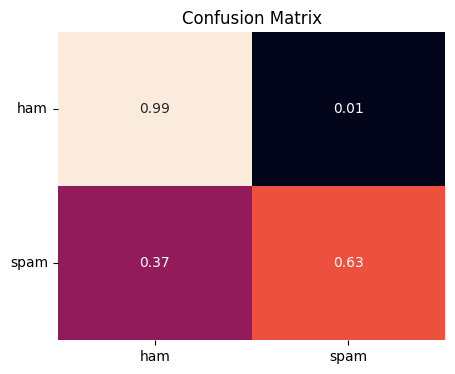

In [7]:
def confusion_matrix_plot(y_test,pred):
    cm=confusion_matrix(y_test,pred)
    cmn=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cmn,annot=True,fmt='.2f',xticklabels=['ham','spam'], yticklabels=['ham','spam'],cbar=False)
    plt.title('Confusion Matrix')
    plt.yticks(rotation=0)

confusion_matrix_plot(y_test,pred)

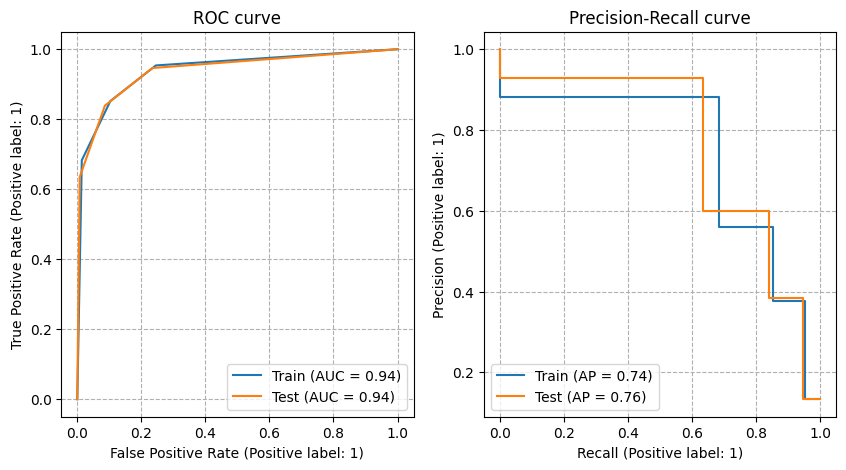

In [11]:
def roc_precison_recall_plot(clf,x_train,x_test,y_train,y_test):
    fig, [ax1,ax2]=plt.subplots(1,2,figsize=(10,5))
    RocCurveDisplay.from_estimator(clf,x_train,y_train,ax=ax1,name='Train')
    RocCurveDisplay.from_estimator(clf,x_test,y_test,ax=ax1,name='Test')

    PrecisionRecallDisplay.from_estimator(clf,docs_train,y_train,ax=ax2,name='Train')
    PrecisionRecallDisplay.from_estimator(clf,docs_test,y_test,ax=ax2,name='Test')

    ax1.set_title('ROC curve')
    ax2.set_title('Precision-Recall curve')

    ax1.grid(linestyle='--')
    ax2.grid(linestyle='--')

roc_precison_recall_plot(clf,docs_train,docs_test,y_train,y_test)

In [19]:
#random forest

pipeline=Pipeline([('tfidf_vectorizer',TfidfVectorizer()),
                   ('svd',TruncatedSVD()),
                    ('clf_rf',RandomForestClassifier(random_state=42))])

param_grid={
    'tfidf_vectorizer__min_df':[10],
    'tfidf_vectorizer__ngram_range':[(1,2),(1,3)],
    'tfidf_vectorizer__max_features':[1000,2000,4000],
    'tfidf_vectorizer__sublinear_tf':[True,False],
    'tfidf_vectorizer__stop_words':[stopwords.words('english')],
    'svd__n_components':[300,400],
    'clf_rf__max_depth':np.arange(2,11).tolist(),
    'clf_rf__min_samples_split':[round(len(docs_train)*0.2)],
    'clf_rf__min_samples_leaf':[round(len(docs_train)*0.1)],
}

grid_search=GridSearchCV(pipeline,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),
                        scoring='accuracy',error_score='raise',n_jobs=-1)

clf_search=grid_search.fit(docs_train,y_train)

cv_results=pd.DataFrame(clf_search.cv_results_)
cv_results.sort_values(by=['rank_test_score','mean_test_score','std_test_score'],
       ascending=[True,False,False])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_rf__max_depth,param_clf_rf__min_samples_leaf,param_clf_rf__min_samples_split,param_svd__n_components,param_tfidf_vectorizer__max_features,param_tfidf_vectorizer__min_df,...,param_tfidf_vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.555920,0.017158,0.034054,0.002012,2,418,836,300,1000,10,...,True,"{'clf_rf__max_depth': 2, 'clf_rf__min_samples_...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
1,1.941511,0.436939,0.042297,0.014960,2,418,836,300,1000,10,...,False,"{'clf_rf__max_depth': 2, 'clf_rf__min_samples_...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
2,1.966709,0.465723,0.045877,0.010788,2,418,836,300,1000,10,...,True,"{'clf_rf__max_depth': 2, 'clf_rf__min_samples_...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
3,2.895052,0.444004,0.062549,0.011955,2,418,836,300,1000,10,...,False,"{'clf_rf__max_depth': 2, 'clf_rf__min_samples_...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
4,2.323701,0.307010,0.044775,0.016640,2,418,836,300,2000,10,...,True,"{'clf_rf__max_depth': 2, 'clf_rf__min_samples_...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2.474051,0.370751,0.045078,0.014815,10,418,836,400,2000,10,...,False,"{'clf_rf__max_depth': 10, 'clf_rf__min_samples...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
212,2.006484,0.023026,0.035386,0.003746,10,418,836,400,4000,10,...,True,"{'clf_rf__max_depth': 10, 'clf_rf__min_samples...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
213,2.385643,0.470283,0.036895,0.004996,10,418,836,400,4000,10,...,False,"{'clf_rf__max_depth': 10, 'clf_rf__min_samples...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1
214,2.077243,0.030564,0.039448,0.003228,10,418,836,400,4000,10,...,True,"{'clf_rf__max_depth': 10, 'clf_rf__min_samples...",0.867225,0.856459,0.876794,0.861244,0.867066,0.865758,0.006819,1


In [20]:
clf=clf_search.best_estimator_
pred=clf.predict(docs_train)
print(classification_report(y_train, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      3618
        spam       0.00      0.00      0.00       561

    accuracy                           0.87      4179
   macro avg       0.43      0.50      0.46      4179
weighted avg       0.75      0.87      0.80      4179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
pred=clf.predict(docs_test)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      1207
        spam       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


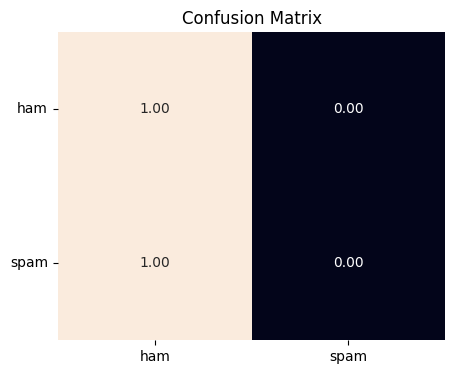

In [22]:
confusion_matrix_plot(y_test,pred)

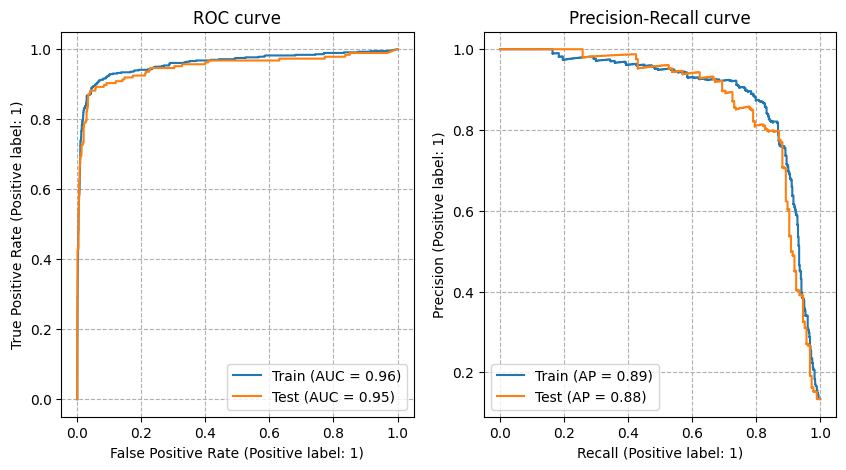

In [23]:
roc_precison_recall_plot(clf,docs_train,docs_test,y_train,y_test)

(array([0.5, 1.5]), [Text(0, 0.5, 'ham'), Text(0, 1.5, 'spam')])

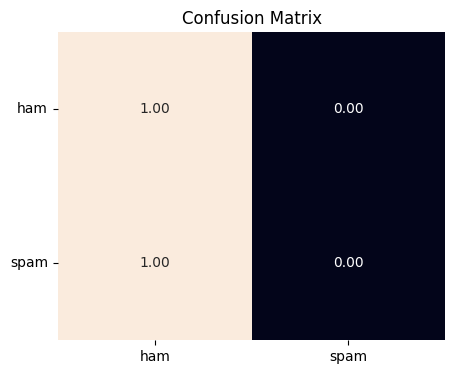

In [24]:
cm=confusion_matrix(y_test,pred)
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['ham','spam'], yticklabels=['ham','spam'],cbar=False)
plt.title('Confusion Matrix')
plt.yticks(rotation=0)

In [25]:
#naive bayes
from scipy.sparse import issparse
class SparseToDenseConverter:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if issparse(X):  # Check if input is sparse
            return X.toarray()  # Convert sparse matrix to dense array
        else:
            return X  # Return unchanged if not sparse

pipeline=Pipeline([('tfidf_vectorizer',TfidfVectorizer()),
                   ('transform',SparseToDenseConverter()),
                    ('svd',TruncatedSVD()),
                    ('clf_nb',GaussianNB())])
param_grid={
    'tfidf_vectorizer__min_df':[10],
    'tfidf_vectorizer__ngram_range':[(1,2),(1,3),(1,4)],
    'tfidf_vectorizer__max_features':[1000,2000,4000],
    'tfidf_vectorizer__sublinear_tf':[True,False],
    'tfidf_vectorizer__stop_words':[stopwords.words('english')],
    'svd__n_components':[300,400],

}

grid_search=GridSearchCV(pipeline,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),
                        scoring='accuracy',n_jobs=-1)

clf_search=grid_search.fit(docs_train,y_train)

In [26]:
cv_results=pd.DataFrame(clf_search.cv_results_)
cv_results.sort_values(by=['rank_test_score','mean_test_score','std_test_score'],
       ascending=[True,False,False]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svd__n_components,param_tfidf_vectorizer__max_features,param_tfidf_vectorizer__min_df,param_tfidf_vectorizer__ngram_range,param_tfidf_vectorizer__stop_words,param_tfidf_vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.704103,0.226432,0.059995,0.021863,300,1000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",False,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.882775,0.885167,0.863636,0.879187,0.868263,0.875806,0.008398,1
6,1.266889,0.016125,0.034308,0.000305,300,2000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.893541,0.877990,0.858852,0.881579,0.863473,0.875087,0.012566,2
0,1.303315,0.028330,0.036936,0.007545,300,1000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.893541,0.880383,0.855263,0.879187,0.864671,0.874609,0.013310,3
15,1.613730,0.178149,0.053972,0.020639,300,4000,10,"(1, 3)","[i, me, my, myself, we, our, ours, ourselves, ...",False,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.885167,0.882775,0.861244,0.870813,0.870659,0.874132,0.008783,4
12,1.461670,0.276959,0.036895,0.004127,300,4000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.886364,0.877990,0.869617,0.880383,0.853892,0.873649,0.011247,5
4,1.423984,0.015441,0.048370,0.008444,300,1000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.885167,0.876794,0.857656,0.880383,0.864671,0.872934,0.010215,6
19,1.685590,0.017305,0.038540,0.003831,400,1000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",False,"{'svd__n_components': 400, 'tfidf_vectorizer__...",0.892344,0.876794,0.869617,0.873206,0.849102,0.872213,0.013915,7
1,1.275909,0.013000,0.036256,0.002814,300,1000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",False,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.882775,0.875598,0.866029,0.874402,0.861078,0.871976,0.007613,8
31,1.978501,0.314104,0.046273,0.016941,400,4000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",False,"{'svd__n_components': 400, 'tfidf_vectorizer__...",0.883971,0.882775,0.879187,0.864833,0.847904,0.871734,0.013731,9
10,1.407608,0.013329,0.044326,0.002413,300,2000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,"{'svd__n_components': 300, 'tfidf_vectorizer__...",0.883971,0.868421,0.855263,0.876794,0.873054,0.871501,0.009582,10


In [27]:
clf=clf_search.best_estimator_
pred=clf.predict(docs_train)
print(classification_report(y_train, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.97      0.90      0.93      3618
        spam       0.56      0.85      0.67       561

    accuracy                           0.89      4179
   macro avg       0.77      0.87      0.80      4179
weighted avg       0.92      0.89      0.90      4179



In [28]:
pred=clf.predict(docs_test)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.98      0.87      0.92      1207
        spam       0.52      0.89      0.65       186

    accuracy                           0.87      1393
   macro avg       0.75      0.88      0.79      1393
weighted avg       0.92      0.87      0.89      1393



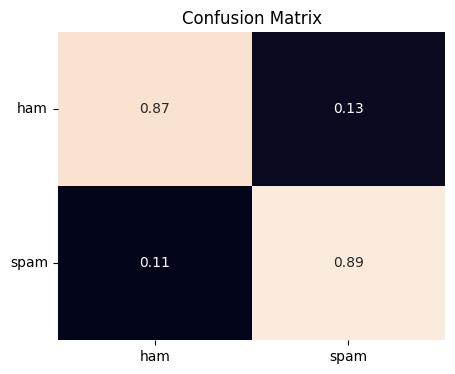

In [29]:
confusion_matrix_plot(y_test,pred)

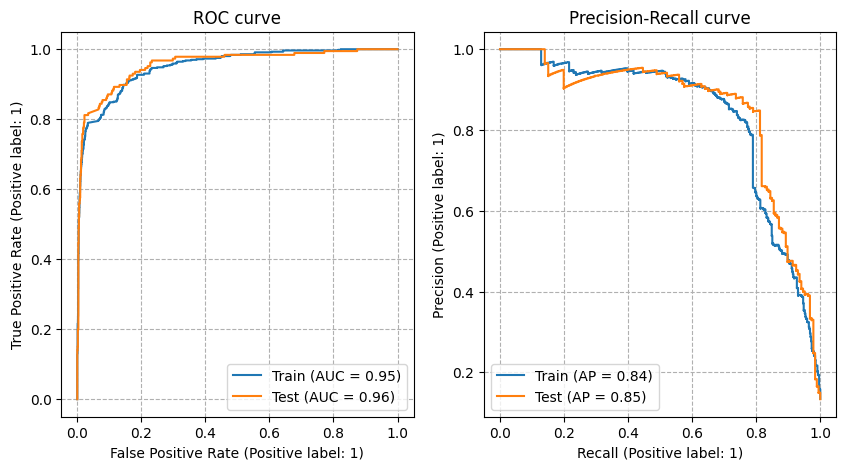

In [30]:
roc_precison_recall_plot(clf,docs_train,docs_test,y_train,y_test)

In [36]:
#adaboost

pipeline=Pipeline([('tfidf_vectorizer',TfidfVectorizer()),
                  ('svd',TruncatedSVD()),
                  ('adaboost',AdaBoostClassifier(random_state=42))])

param_grid={
    'tfidf_vectorizer__min_df':[10],
    'tfidf_vectorizer__ngram_range':[(1,2),(1,3),(1,4)],
    'tfidf_vectorizer__max_features':[1000,2000,4000],
    'tfidf_vectorizer__sublinear_tf':[True,False],
    'tfidf_vectorizer__stop_words':[stopwords.words('english')],
    'svd__n_components':[300,400],
    'adaboost__estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],
}

grid_search=GridSearchCV(pipeline,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),
                        scoring='accuracy',n_jobs=-1)

clf_search=grid_search.fit(docs_train,y_train)

cv_results=pd.DataFrame(clf_search.cv_results_)
cv_results.sort_values(by=['rank_test_score','mean_test_score','std_test_score'],
       ascending=[True,False,False]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adaboost__estimator,param_svd__n_components,param_tfidf_vectorizer__max_features,param_tfidf_vectorizer__min_df,param_tfidf_vectorizer__ngram_range,param_tfidf_vectorizer__stop_words,param_tfidf_vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,16.041598,1.305334,0.053827,0.014953,DecisionTreeClassifier(max_depth=2),300,4000,10,"(1, 3)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.978469,0.971292,0.977273,0.982057,0.974850,0.976788,0.003600,1
34,20.373570,0.460416,0.056340,0.004767,DecisionTreeClassifier(max_depth=2),400,4000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.980861,0.968900,0.977273,0.976077,0.979641,0.976550,0.004181,2
30,20.211983,0.424296,0.046271,0.000598,DecisionTreeClassifier(max_depth=2),400,4000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.979665,0.970096,0.976077,0.976077,0.974850,0.975353,0.003083,3
10,15.330945,0.355246,0.050115,0.001703,DecisionTreeClassifier(max_depth=2),300,2000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.980861,0.971292,0.971292,0.970096,0.978443,0.974397,0.004380,4
6,15.305302,0.368741,0.043282,0.002177,DecisionTreeClassifier(max_depth=2),300,2000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.980861,0.970096,0.974880,0.968900,0.977246,0.974396,0.004447,5
18,20.213675,0.410719,0.058318,0.021264,DecisionTreeClassifier(max_depth=2),400,1000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.980861,0.966507,0.971292,0.972488,0.978443,0.973918,0.005149,6
22,20.598855,0.376046,0.053861,0.000946,DecisionTreeClassifier(max_depth=2),400,1000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.977273,0.968900,0.976077,0.977273,0.968862,0.973677,0.003940,7
28,20.401373,0.518816,0.055894,0.001078,DecisionTreeClassifier(max_depth=2),400,2000,10,"(1, 4)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.978469,0.966507,0.976077,0.974880,0.970060,0.973199,0.004325,8
2,15.633635,0.818357,0.058576,0.025349,DecisionTreeClassifier(max_depth=2),300,1000,10,"(1, 3)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.977273,0.970096,0.965311,0.974880,0.977246,0.972961,0.004634,9
24,20.232413,0.471560,0.057178,0.021692,DecisionTreeClassifier(max_depth=2),400,2000,10,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",True,{'adaboost__estimator': DecisionTreeClassifier...,0.983254,0.960526,0.972488,0.974880,0.973653,0.972960,0.007279,10


In [37]:
clf=clf_search.best_estimator_
pred=clf.predict(docs_train)
print(classification_report(y_train, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3618
        spam       1.00      0.99      1.00       561

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179



In [38]:
pred=clf.predict(docs_test)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1207
        spam       0.92      0.91      0.92       186

    accuracy                           0.98      1393
   macro avg       0.96      0.95      0.95      1393
weighted avg       0.98      0.98      0.98      1393



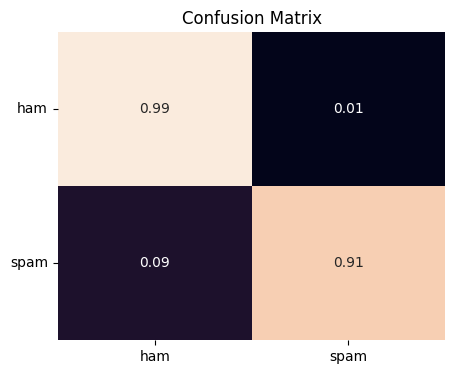

In [39]:
confusion_matrix_plot(y_test,pred)

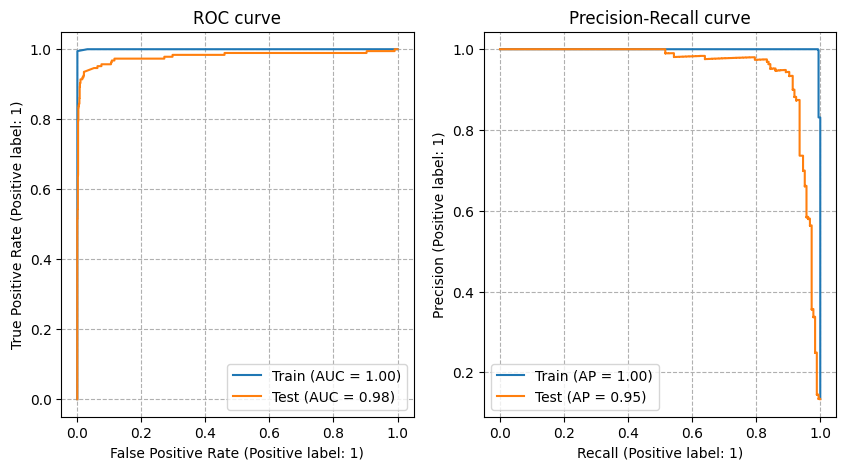

In [40]:
roc_precison_recall_plot(clf,docs_train,docs_test,y_train,y_test)

In [ ]:
#xgboost

pipeline=Pipeline([('tfidf_vectorizer',TfidfVectorizer()),
                  ('svd',TruncatedSVD()),
                  ('xgb',xgb.XGBRegressor(random_state=42,n_jpbs=-1))])

param_grid={
    'tfidf_vectorizer__min_df':[10],
    'tfidf_vectorizer__ngram_range':[(1,2),(1,3),(1,4)],
    'tfidf_vectorizer__max_features':[1000,2000,4000],
    'tfidf_vectorizer__sublinear_tf':[True,False],
    'tfidf_vectorizer__stop_words':[stopwords.words('english')],
    'svd__n_components':[300,400],
    'xgb__max_depth': np.arange(2,11,1).tolist(),
    'xgb__alpha': np.arange(0,2.5,0.5).tolist(),
    'xgb__lambda': np.arange(0,2,0.5).tolist(),
}

grid_search=GridSearchCV(pipeline,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),
                        scoring='accuracy',n_jobs=-1)

clf_search=grid_search.fit(docs_train,y_train)

In [ ]:
cv_results=pd.DataFrame(clf_search.cv_results_)
cv_results.sort_values(by=['rank_test_score','mean_test_score','std_test_score'],
       ascending=[True,False,False]).head(10)

In [ ]:
clf=clf_search.best_estimator_
pred=clf.predict(docs_train)
print(classification_report(y_train, pred, target_names=['ham','spam']))

In [ ]:
pred=clf.predict(docs_test)
print(classification_report(y_test, pred, target_names=['ham','spam']))

In [ ]:
roc_precison_recall_plot(clf,docs_train,docs_test,y_train,y_test)